<a href="https://colab.research.google.com/github/matthewchung74/segmed/blob/main/Segmed_Sample_DICOM_Dataset_1647.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://images.squarespace-cdn.com/content/v1/5e5db7f1ded5fc06a4e9628b/1621962211656-VRF2N22QPR0HWGVJHG7G/logo+black.png?format=300w)
### Segmed Sample Dicom Dataset
<br>
👋 Hello there - we’re glad you found us! 
<br>
<br>
This sample deidentified dataset is an example of what's available on Segmed Insight - **our proprietary platform with nearly 10 million reports**.

[Schedule a demo to learn more and gain access to Insight](https://calendly.com/d/dr3-5n8-mjd/segmed-demo-request).
<br>
<br>
This notebook contains chest x-ray reports and dicom images.
<br>
<br>
In addition to the Insight platform, there’s a concierge team that can help source data if you can’t find what you’re looking for. Contact Aline at aline@segmed.ai if you have any questions.
<br>
<br>
We pride ourselves on getting quality data to people like you faster than any other platform or option on the market. 

Modalities available at [Segmed.ai](https://segmed.ai) are:

*   Mammo
*   Ultrasound
*   CT
*   PET
*   X-ray
*   MR
*   10+ available

Body parts available include:
* Head/Neck
* Brain/Head 
* Breast
* Cardiac
* Liver/spleen
* Aorta
* 50+ available

[Schedule a demo](https://calendly.com/d/dr3-5n8-mjd/segmed-demo-request), and we’ll help you build better products!

### Install and import dependencies

First let's install dependencies so we can view the dicoms. This tutorial will make use [pydicom](https://github.com/pydicom/pydicom).

In [8]:
%pip install -q pydicom
%pip install -q pillow
%pip install -q pylibjpeg[all]
%pip install -q python-gdcm

In [9]:
!git clone --quiet --recurse-submodules https://github.com/pydicom/pylibjpeg-libjpeg
%pip install pylibjpeg-libjpeg

fatal: destination path 'pylibjpeg-libjpeg' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from glob import glob
import pydicom
import os
from PIL import Image
import pylibjpeg 
from pydicom.pixel_data_handlers.pylibjpeg_handler import generate_frames

### Download dataset and summary file

Every dataset downloaded from segmed consists of a summary file and zip of data, based on the dataset name. Let's download and unpack this dataset.

In [11]:
!wget -nc https://dices.s3.amazonaws.com/1674-dataset-for-notebook-samples-summary-1663606868.csv
!wget -nc https://dices.s3.amazonaws.com/1674-dataset-for-notebook-samples-0-1663606868.zip
!unzip -qo 1674-dataset-for-notebook-samples-0-1663606868.zip -d ./dataset

File ‘1674-dataset-for-notebook-samples-summary-1663606868.csv’ already there; not retrieving.

File ‘1674-dataset-for-notebook-samples-0-1663606868.zip’ already there; not retrieving.



The summary file contains the study id and the medical report for each of the studies. You can see from the following that there are 5 studies downloaded in this dataset, each with about 2 dicoms per study and deidentified report.

In [12]:
df = pd.DataFrame(pd.read_csv('1674-dataset-for-notebook-samples-summary-1663606868.csv'), columns=['Study ID', 'Report'])

dicoms_in_study_length = []
dicoms = []
for study_id in df['Study ID'].to_numpy():
  dicoms_in_study = glob(f'dataset/{study_id}/**/*.dcm', recursive=True)
  dicoms_in_study_length.append(len(dicoms_in_study))
  dicoms.append(dicoms_in_study)
dicoms = np.ravel(dicoms)
df['Num Dicoms'] = dicoms_in_study_length
df[['Report', 'Num Dicoms']]

,Report,Num Dicoms
0,CHEST XRAY PA AND LATERAL HISTORY: Z00.00 Rout...,2
1,CHEST RADIOGRAPH: PA and Lateral views HISTORY...,2
2,CHEST XRAY PA AND LATERAL HISTORY: R05 Cough Z...,2
3,CHEST XRAY PA AND LATERAL HISTORY: R05 Cough R...,2
4,CHEST XRAY PA AND LATERAL HISTORY: R05 Cough R...,2


### Exploratory Data Analysis

Let's first visualize the images. As you can see, there are 4 dicom images with the original formatting and resolution from the radiology clinic. 

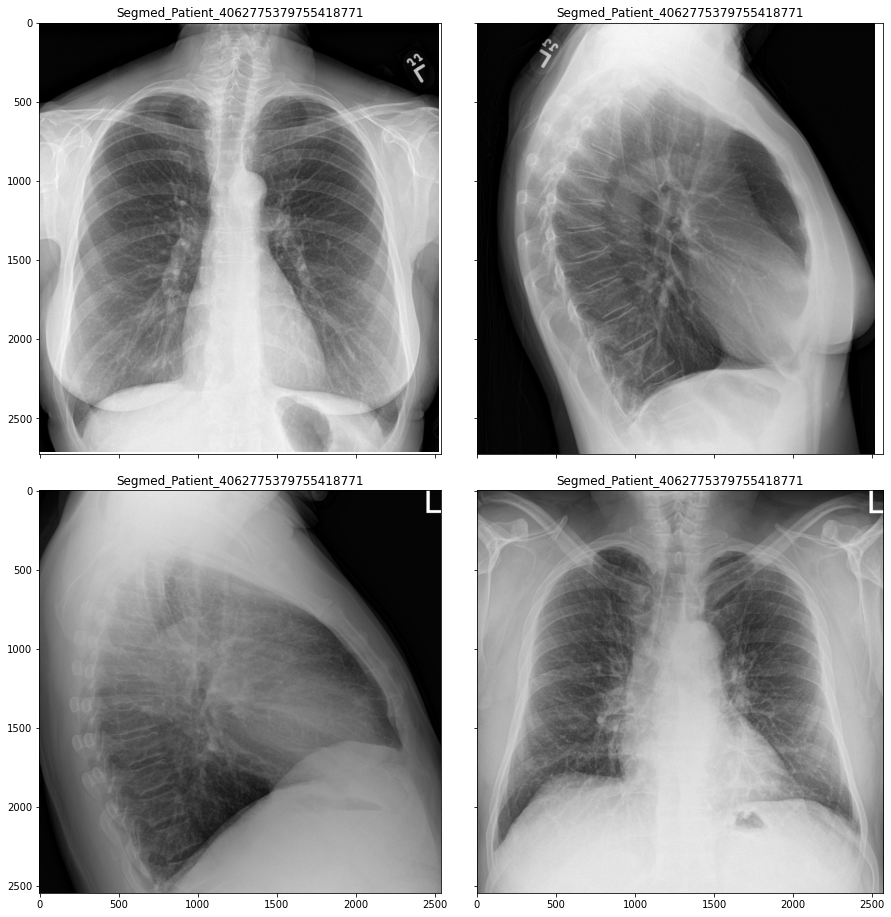

In [13]:
from io import BytesIO
from PIL import Image
from pydicom import dcmread
from pydicom.encaps import generate_pixel_data_frame
from libjpeg import decode

ds_array = []
final_images = []
for dicom_path in dicoms.tolist():
  ds = pydicom.dcmread(dicom_path, force=False)
  if ds.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.70':
    new_image = ds.pixel_array.astype(float)
    scaled_image = (np.maximum(new_image, 0) / new_image.max()) * 255.0
    scaled_image = np.uint8(scaled_image)
    final_image = Image.fromarray(scaled_image)
    final_images.append(final_image)

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(2, 2),  
                 axes_pad=0.5,  
                 )

for ax, im in zip(grid, final_images):
    ax.set_title(ds.data_element('PatientName').value)
    ax.imshow(im, cmap='gray')

Let's take a look at the entire dicom contents of the first dicom. Notice several fields contain Segmed_ tags for deidentification purposes.

And finally let's review the metadata for the last dicom.

In [14]:
ds

/usr/local/lib/python3.7/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.3.6.1.4.1.55648.037844487153450374793635623288998.1.1'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.3.6.1.4.1.55648.037844487153450374793635623288998'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.3.6.1.4.1.55648.037844487153450374793635623288998.1'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.55648.037844487153450374793635623288998.1.1
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.55648.0.1.619.0
(0002, 0013) Implementation Version Name         SH: 'Segmed_v1.619.0'
(0002, 0016) Source Application Entity Title     AE: 'Segmed.ai\x00'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Computed Radiography I